# Sentiment Analysis and Machine Learning on Educational Reviews

This project performs sentiment analysis on educational reviews from the `course_data_clean.cs, `course_data_clean.csv`v` dataset. The goal is to evaluate and compare the effectiveness of various sentiment analysis models and machine learning classifiers in predicting the sentiment of course reviews.

## Project Overview

- **Data Collection**: Utilizes course reviews data to analyze sentiment.
- **Data Preprocessing**: Cleans the text data by removing URLs, special characters, and extra spaces to prepare it for analysis.
- **Sentiment Analysis Models**:
  - **TextBlob**: Provides a simple API for diving into common natural language processing (NLP) tasks.
  - **VADER**: A lexicon and rule-based sentiment analysis tool specifically attuned to sentiments expressed in social media.
  - **Transformers (DistilBERT)**: Uses a transformer-based model fine-tuned for sentiment analysis to provide more nuanced sentiment scores.

- **Machine Learning Models**:
  - **Logistic Regression**: A linear model for binary classification tasks.
  - **Support Vector Machine (SVM)**: A powerful classifier that works well with high-dimensional data.
  - **Random Forest**: An ensemble method that combines multiple decision trees to improve classification accuracy.

## Evaluation and Validation

- **Metrics**: The models are evaluated using accuracy, precision, recall, and F1-score.
- **Comparison with Ratings**: Sentiment analysis results are compared with actual course ratings to determine true positives, false positives, true negatives, and false negatives.
- **Visualization**: Confusion matrices and bar graphs are used to visualize the distribution of ratings  potential PhD candidates.

In [24]:
# Import the prerequisite libraries
# Data specific libraries
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

# Data analysis specific libraries
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, precision_recall_fscore_support, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils import resample

# Machine learning algorithm libraries
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import SGDClassifier

# Sentiment analysis libraires
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from transformers import pipeline

## Dataset description
**inputs/course_data_clean.csv**:<br>
The dataset contains reviews at the course-review level. The motivation behind creating this dataset was to train a classifier that could determine, based on the course review, whether the reviewer had a positive or negative experience with the course. All of the reviews in the dataset were obtained from the website uwflow.com.
<br>

The dataset was downloaded from _https://www.kaggle.com/datasets/anthonysusevski/course-reviews-university-of-waterloo/data_
<br><br>
**inputs/collegereview2021.csv**:<br>
This dataset contains all the Engineering college reviews for colleges in India . I scraped the data from Collegedunia website. The data contains 4 variables:

* Username
* College Name
* Review
* Rating

The dataset was downloaded from _https://www.kaggle.com/datasets/anthonysusevski/course-reviews-university-of-waterloo/data_

## Gather and organize the data

In [2]:
# Loading the datasets
waterloo_data = pd.read_csv('inputs/course_data_clean.csv')
college21_data = pd.read_csv('inputs/collegereview2021.csv')

In [3]:
# Examining the data
pd.set_option('display.max_columns', None) # This will allow the program to show all column information in the dataset
waterloo_data.head()

,course_code,course_title,num_ratings,useful,easy,liked,num_reviews,reviews,course_rating,course_rating_int
0,CS 115,Introduction to Computer Science 1,2111,21%,10%,23%,86,go to office hours and practice,liked course,1.0
1,CS 115,Introduction to Computer Science 1,2111,21%,10%,23%,86,One of my least favourite courses. Although th...,disliked course,0.0
2,CS 115,Introduction to Computer Science 1,2111,21%,10%,23%,86,It starts with a very low pace but after midte...,disliked course,0.0
3,CS 115,Introduction to Computer Science 1,2111,21%,10%,23%,86,Took this in 2018 with no programming experien...,liked course,1.0
4,CS 115,Introduction to Computer Science 1,2111,21%,10%,23%,86,I loved everything about cs 115. Great instruc...,liked course,1.0


The __.shape()__ method will display the number of rows and number of columns in the dataset

In [4]:
# Shape of the dataset
print("Dataset shape:", waterloo_data.shape)

Dataset shape: (14838, 10)


The __.info()__ method will print information on the dataset to the user. In particular, we will need to identify if there is any missing data _(via the Non-Null Count)_ and if there are any object datatypes within the dataframe. Likewise, it will also provide the number of rows and columns via the _RangeIndex_ and _Data columns_ labels, respectively. <br>

In [5]:
# Open concise summary of the dataframe
waterloo_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14838 entries, 0 to 14837
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   course_code        14838 non-null  object 
 1   course_title       14838 non-null  object 
 2   num_ratings        14838 non-null  int64  
 3   useful             14836 non-null  object 
 4   easy               14835 non-null  object 
 5   liked              14835 non-null  object 
 6   num_reviews        14838 non-null  int64  
 7   reviews            14829 non-null  object 
 8   course_rating      14616 non-null  object 
 9   course_rating_int  14616 non-null  float64
dtypes: float64(1), int64(2), object(7)
memory usage: 1.1+ MB


For extra measure, we can gather statistics on the dataframe's numerical columns. From the output, it appears some of the columns have higher variance than the others (e.g., web_traffic, ratio_intMedia, safe_anchor, etc.), which is due to these columns having larger values and ranges.

In [6]:
waterloo_data.describe()

,num_ratings,num_reviews,course_rating_int
count,14838.000000,14838.000000,14616.000000
mean,238.956733,45.831379,0.669540
std,308.523872,54.487423,0.470395
min,0.000000,1.000000,0.000000
25%,33.000000,7.000000,0.000000
50%,104.000000,22.000000,1.000000
75%,341.000000,66.000000,1.000000
max,2111.000000,253.000000,1.000000


We need to determine if the dataset is balanced or not. We can check the frequency of unique classes in the dataset through the __.unique()__ and __.value_counts(()__ method.

In [7]:
# Unique occurrences of the course_rating columns
print("Unique classes in the course_rating column: ", waterloo_data['course_rating'].unique(), end="\n\n")
# Counting the values within each course_rating column
category_dist = waterloo_data['course_rating'].value_counts()
print(category_dist)

Unique classes in the course_rating column:  ['liked course' 'disliked course' nan]

course_rating
liked course       9786
disliked course    4830
Name: count, dtype: int64


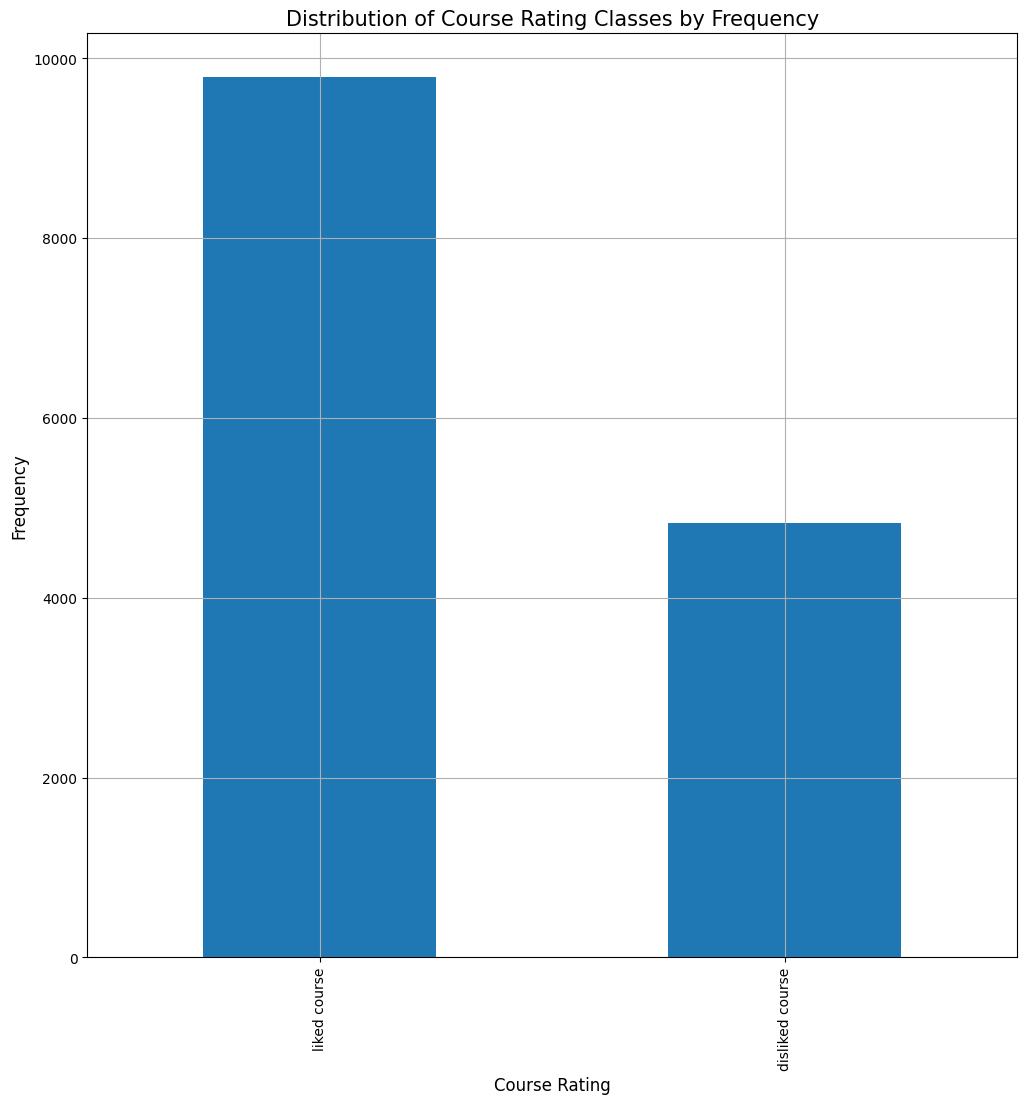

In [8]:
# Defining the chart
plt.figure(figsize=(12,12))
category_dist.plot(kind='bar')
plt.grid()
plt.xlabel("Course Rating", fontsize = 12)
plt.ylabel("Frequency", fontsize = 12)
plt.title("Distribution of Course Rating Classes by Frequency", fontsize = 15)
plt.savefig("waterloo_data_1.png", format='png', dpi=500, bbox_inches='tight')

#Generating chart
plt.show()

The dataset is not balanced, and may introduce bias if the data is trained in a machine learning model. 

In [9]:
# Separate the majority and minority classes
liked = waterloo_data[waterloo_data['course_rating'] == 'liked course']
disliked = waterloo_data[waterloo_data['course_rating'] == 'disliked course']

In [10]:
# Undersample the majority class
liked_downsampled = resample(liked,
                            replace=False, # sample without replacement
                            n_samples=len(disliked), #match the number of disliked,
random_state=42) #reproducible results

In [11]:
# Combine the downsampled majority class with the minority class
balanced_data = pd.concat([liked_downsampled, disliked])

In [12]:
# Display the new class distribution
print(balanced_data['course_rating'].value_counts())
category_dist = balanced_data['course_rating'].value_counts()
print(category_dist)

course_rating
liked course       4830
disliked course    4830
Name: count, dtype: int64
course_rating
liked course       4830
disliked course    4830
Name: count, dtype: int64


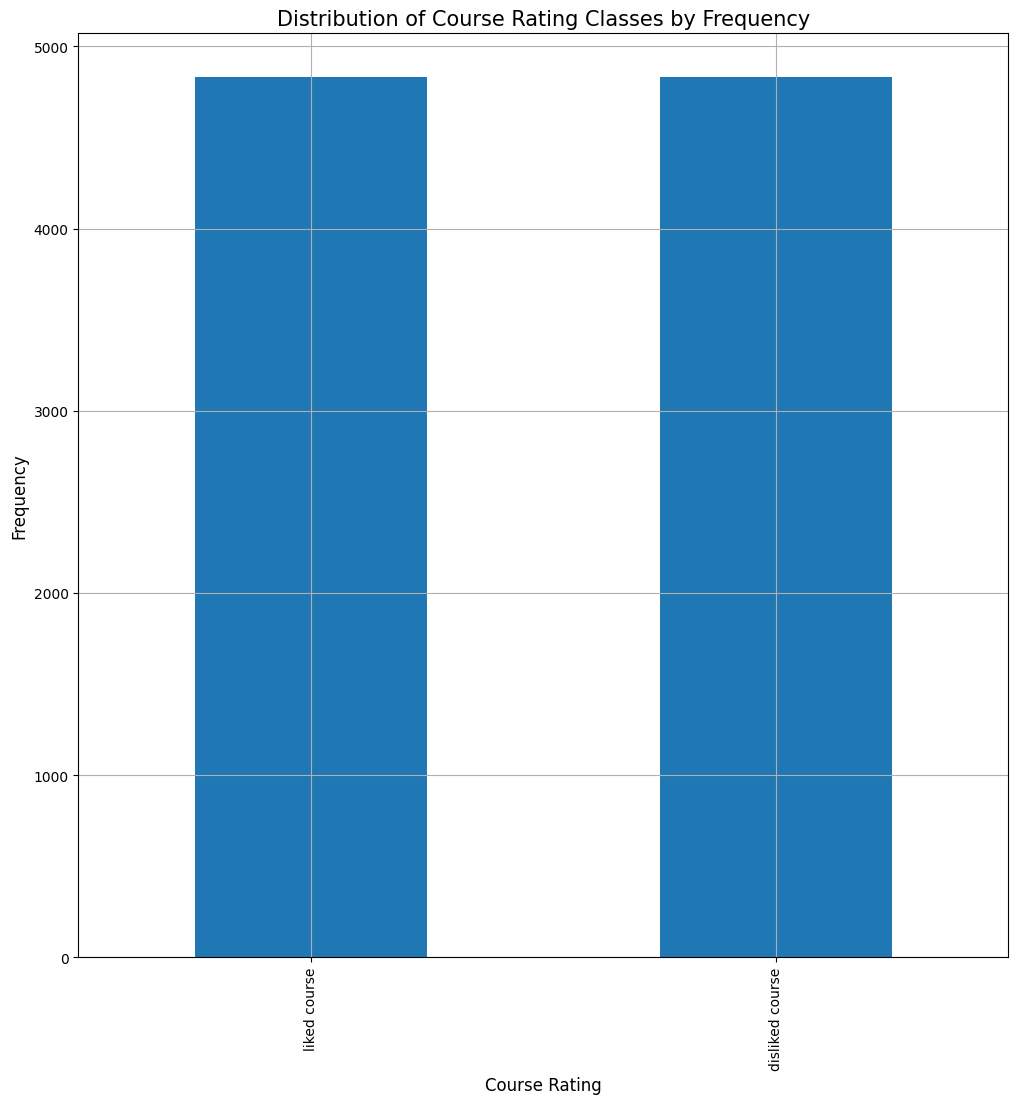

In [13]:
# Defining the chart
plt.figure(figsize=(12,12))
category_dist.plot(kind='bar')
plt.grid()
plt.xlabel("Course Rating", fontsize = 12)
plt.ylabel("Frequency", fontsize = 12)
plt.title("Distribution of Course Rating Classes by Frequency", fontsize = 15)
plt.savefig("waterloo_data_1.png", format='png', dpi=500, bbox_inches='tight')

#Generating chart
plt.show()

## Perform data cleaning on the text reviews

In [14]:
# Data cleaning
def clean_text(text):
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'\@\w+|\#', '', text)
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)
    text = re.sub(r'\s+', ' ', text, flags=re.I)
    return text.strip()

balanced_data['cleaned_reviews'] = balanced_data['reviews'].astype(str).apply(clean_text)

In [15]:
balanced_data.head()

,course_code,course_title,num_ratings,useful,easy,liked,num_reviews,reviews,course_rating,course_rating_int,cleaned_reviews
13716,ITALST 111,Marriage and Family Traditions in Italy,7,36%,96%,100%,4,This was a relatively easy class but there was...,liked course,1.0,This was relatively easy class but there was l...
11021,CS 492,The Social Implications of Computing,34,47%,90%,68%,13,Sooooooooooo fucking easy. Just write bullshit...,liked course,1.0,Sooooooooooo fucking easy Just write bullshit ...
7268,FR 192A,French Language 1: Module 1,111,89%,77%,77%,17,This course was similar format to the 151/152 ...,liked course,1.0,This course was similar format to the 151 152 ...
9638,MTE 360,Automatic Control Systems,53,100%,14%,81%,11,FEEDBACK CONTROL,liked course,1.0,FEEDBACK CONTROL
10692,CS 365,Models of Computation,37,62%,47%,70%,7,This course was super interesting and it's eas...,liked course,1.0,This course was super interesting and it easil...


In [16]:
# Sentiment analysis with TextBlob
def textblob_sentiment(text):
    analysis = TextBlob(text)
    return 1 if analysis.sentiment.polarity > 0 else 0

balanced_data['textblob_label'] = balanced_data['cleaned_reviews'].apply(textblob_sentiment)

In [17]:
# Sentiment analysis with VADER
vader_analyzer = SentimentIntensityAnalyzer()

def vader_sentiment(text):
    return 1 if vader_analyzer.polarity_scores(text)['compound'] > 0 else 0

balanced_data['vader_label'] = balanced_data['cleaned_reviews'].apply(vader_sentiment)

In [18]:
# Sentiment analysis with transformers
transformer_analyzer = pipeline('sentiment-analysis', model="distilbert-base-uncased-finetuned-sst-2-english")

def transformer_sentiment(text):
    result = transformer_analyzer(text, truncation=True, max_length=512)
    return 1 if result[0]['label'] == 'POSITIVE' else 0

balanced_data['transformer_label'] = balanced_data['cleaned_reviews'].apply(transformer_sentiment)

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [19]:
# Compare with actual ratings
balanced_data['actual_label'] = balanced_data['course_rating'].apply(lambda x: 1 if x == 'liked course' else 0)

In [20]:
# Evaluate the models
def evaluate_model(predictions, actual):
    accuracy = accuracy_score(actual, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(actual, predictions, average='binary')
    return accuracy, precision, recall, f1

models = ['textblob', 'vader', 'transformer']
results = {}

for model in models:
    accuracy, precision, recall, f1 = evaluate_model(balanced_data[f'{model}_label'], balanced_data['actual_label'])
    results[model] = {'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1}

In [21]:
# Display results
for model, metrics in results.items():
    print(f"{model.capitalize()} Model:")
    print(f"Accuracy: {metrics['accuracy']:.2f}")
    print(f"Precision: {metrics['precision']:.2f}")
    print(f"Recall: {metrics['recall']:.2f}")
    print(f"F1 Score: {metrics['f1']:.2f}\n")

Textblob Model:
Accuracy: 0.66
Precision: 0.62
Recall: 0.84
F1 Score: 0.71

Vader Model:
Accuracy: 0.67
Precision: 0.63
Recall: 0.84
F1 Score: 0.72

Transformer Model:
Accuracy: 0.72
Precision: 0.77
Recall: 0.63
F1 Score: 0.69



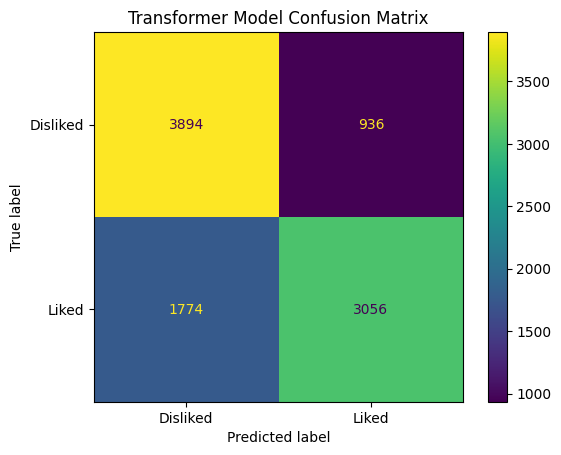

In [25]:
# Plot confusion matrix for one model (e.g., Transformer)
cm = confusion_matrix(balanced_data['actual_label'], balanced_data['transformer_label'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Disliked', 'Liked'])
disp.plot()
plt.title('Transformer Model Confusion Matrix')
plt.show()